# Práctica 4: Modelos del Lenguaje Neuronales

**Fecha de entrega: 6 de abril de 2025 11:59pm**

In [ ]:
#!jupytext --set-formats ipynb,py 04_Modelos_del_Lenguaje_Neuronales.ipynb

[jupytext] Reading 04_Modelos_del_Lenguaje_Neuronales.ipynb in format ipynb
[jupytext] Updating notebook metadata with '{"jupytext": {"formats": "ipynb,py"}}'
[jupytext] Updating 04_Modelos_del_Lenguaje_Neuronales.ipynb
[jupytext] Updating 04_Modelos_del_Lenguaje_Neuronales.py


## Ejercicio 1.

A partir del modelo entrenado:

- Sacar los embeddings de las palabras del vocabulario

- Visualizar en 2D los embeddings de algunas palabras (quizá las más frecuentes, excluyendo stopwords)

- Seleccione algunas palabras y verifique sí realmente codifican nociones semánticas, e,g, similitud semántica con similitud coseno entre dos vectores, analogías por medios de operaciones de vectores

In [1]:
# Bibliotecas
import nltk

### Definición del modelo

In [2]:
nltk.download('reuters')
nltk.download('punkt_tab')

from nltk.corpus import reuters
from nltk import ngrams

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
def preprocess_corpus(corpus: list[str]) -> list[str]:
    """Función de preprocesamiento

    Esta función está diseñada para preprocesar
    corpus para modelos del lenguaje neuronales.
    Agrega tokens de inicio y fin, normaliza
    palabras a minusculas
    """
    preprocessed_corpus = []
    for sent in corpus:
        result = [word.lower() for word in sent]
        # Al final de la oración
        result.append("<EOS>")
        result.insert(0, "<BOS>")
        preprocessed_corpus.append(result)
    return preprocessed_corpus

In [4]:
def get_words_freqs(corpus: list[list[str]]):
    """Calcula la frecuencia de las palabras en un corpus"""
    words_freqs = {}
    for sentence in corpus:
        for word in sentence:
            words_freqs[word] = words_freqs.get(word, 0) + 1
    return words_freqs

In [5]:
UNK_LABEL = "<UNK>"
def get_words_indexes(words_freqs: dict) -> dict:
    """Calcula los indices de las palabras dadas sus frecuencias"""
    result = {}
    for idx, word in enumerate(words_freqs.keys()):
        # Happax legomena happends
        if words_freqs[word] == 1:
            # Temp index for unknowns
            result[UNK_LABEL] = len(words_freqs)
        else:
            result[word] = idx

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [6]:
corpus = preprocess_corpus(reuters.sents())

In [7]:
words_freqs = get_words_freqs(corpus)

In [8]:
count = 0
for word, freq in words_freqs.items():
    if freq == 1 and count <= 10:
        print(word, freq)
        count += 1

inflict 1
sheen 1
avowed 1
kilolitres 1
janunary 1
pineapples 1
hasrul 1
paian 1
sawn 1
goodall 1
bundey 1


In [9]:
words_indexes, index_to_word = get_words_indexes(words_freqs)

In [10]:
words_indexes["the"]

16

In [11]:
words_indexes["women"]

3222

In [12]:
index_to_word[16]

'the'

In [13]:
len(words_indexes)

20056

In [14]:
len(index_to_word)

20056

In [15]:
def get_word_id(words_indexes: dict, word: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK
    """
    unk_word_id = words_indexes[UNK_LABEL]
    return words_indexes.get(word, unk_word_id)

### Obtenemos trigramas

Convertiremos los trigramas obtenidos a secuencias de idx, y preparamos el conjunto de entrenamiento $x$ y $y$

- x: Contexto
- y: Predicción de la siguiente palabra

In [16]:
def get_train_test_data(corpus: list[list[str]], words_indexes: dict, n: int) -> tuple[list, list]:
    """Obtiene el conjunto de train y test

    Requerido en el step de entrenamiento del modelo neuronal
    """
    x_train = []
    y_train = []
    for sent in corpus:
        n_grams = ngrams(sent, n)
        for w1, w2, w3 in n_grams:
            x_train.append([get_word_id(words_indexes, w1), get_word_id(words_indexes, w2)])
            y_train.append([get_word_id(words_indexes, w3)])
    return x_train, y_train

### Preparando Pytorch

$x' = e(x_1) \oplus e(x_2)$

$h = \tanh(W_1 x' + b)$

$y = softmax(W_2 h)$

In [17]:
# cargamos bibliotecas
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

In [18]:
# Setup de parametros
EMBEDDING_DIM = 200
CONTEXT_SIZE = 2
BATCH_SIZE = 256
H = 100
torch.manual_seed(42)
# Tamaño del Vocabulario
V = len(words_indexes)

In [19]:
x_train, y_train = get_train_test_data(corpus, words_indexes, n=3)

In [20]:
import numpy as np

train_set = np.concatenate((x_train, y_train), axis=1)
# partimos los datos de entrada en batches
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)

### Creamos la arquitectura del modelo

In [21]:
# Trigram Neural Network Model
class TrigramModel(nn.Module):
    """Clase padre: https://pytorch.org/docs/stable/generated/torch.nn.Module.html"""

    def __init__(self, vocab_size, embedding_dim, context_size, h):
        super(TrigramModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        self.linear2 = nn.Linear(h, vocab_size)

    def forward(self, inputs):
        # x': concatenation of x1 and x2 embeddings   -->
        # self.embeddings regresa un vector por cada uno de los índices que se les pase como entrada.
        # view() les cambia el tamaño para concatenarlos
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # h: tanh(W_1.x' + b)  -->
        out = torch.tanh(self.linear1(embeds))
        # W_2.h                 -->
        out = self.linear2(out)
        # log_softmax(W_2.h)      -->
        # dim=1 para que opere sobre renglones, pues al usar batchs tenemos varios vectores de salida
        log_probs = F.log_softmax(out, dim=1)

        return log_probs

In [22]:
# Seleccionar la GPU si está disponible
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [23]:
device

'cuda'

In [24]:
#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")

# 1. Pérdida. Negative log-likelihood loss
loss_function = nn.NLLLoss()

# 2. Instanciar el modelo y enviarlo a device
model = TrigramModel(V, EMBEDDING_DIM, CONTEXT_SIZE, H).to(device)

# 3. Optimización. ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

# ------------------------- TRAIN & SAVE MODEL ------------------------
EPOCHS = 3
for epoch in range(EPOCHS):
    st = time.time()
    print("\n--- Training model Epoch: {} ---".format(epoch))
    for it, data_tensor in enumerate(train_loader):
        # Mover los datos a la GPU
        context_tensor = data_tensor[:,0:2].to(device)
        target_tensor = data_tensor[:,2].to(device)

        model.zero_grad()

        # FORWARD:
        log_probs = model(context_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # BACKWARD:
        loss.backward()
        optimizer.step()

        if it % 500 == 0:
            print("Training Iteration {} of epoch {} complete. Loss: {}; Time taken (s): {}".format(it, epoch, loss.item(), (time.time()-st)))
            st = time.time()
'''
    # saving model
    model_path = f'/content/drive/MyDrive/8vo Semestre/LM_neuronal/model_{device}_context_{CONTEXT_SIZE}_epoch_{epoch}.dat'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved for epoch={epoch} at {model_path}")
'''


Training on device cuda

--- Training model Epoch: 0 ---
Training Iteration 0 of epoch 0 complete. Loss: 9.939767837524414; Time taken (s): 0.6447601318359375
Training Iteration 500 of epoch 0 complete. Loss: 5.791378498077393; Time taken (s): 1.9853990077972412
Training Iteration 1000 of epoch 0 complete. Loss: 5.2173237800598145; Time taken (s): 1.9023663997650146
Training Iteration 1500 of epoch 0 complete. Loss: 3.948838710784912; Time taken (s): 1.9679269790649414
Training Iteration 2000 of epoch 0 complete. Loss: 5.0632758140563965; Time taken (s): 1.9369378089904785
Training Iteration 2500 of epoch 0 complete. Loss: 4.599884033203125; Time taken (s): 1.9134876728057861
Training Iteration 3000 of epoch 0 complete. Loss: 4.076411724090576; Time taken (s): 1.9114062786102295
Training Iteration 3500 of epoch 0 complete. Loss: 4.5474114418029785; Time taken (s): 1.9086799621582031
Training Iteration 4000 of epoch 0 complete. Loss: 5.639535903930664; Time taken (s): 1.9103901386260986

'\n    # saving model\n    model_path = f\'/content/drive/MyDrive/8vo Semestre/LM_neuronal/model_{device}_context_{CONTEXT_SIZE}_epoch_{epoch}.dat\'\n    torch.save(model.state_dict(), model_path)\n    print(f"Model saved for epoch={epoch} at {model_path}")\n'

In [25]:
model

TrigramModel(
  (embeddings): Embedding(20056, 200)
  (linear1): Linear(in_features=400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=20056, bias=True)
)

In [26]:
#model = get_model(PATH)
W1 = "<BOS>"
W2 = "my"

IDX1 = get_word_id(words_indexes, W1)
IDX2 = get_word_id(words_indexes, W2)

#Obtenemos Log probabidades p(W3|W2,W1)
probs = model(torch.tensor([[IDX1,  IDX2]]).to(device)).detach().tolist()

In [27]:
len(probs[0])

20056

In [28]:
# Creamos diccionario con {idx: logprob}
model_probs = {}
for idx, p in enumerate(probs[0]):
  model_probs[idx] = p

# Sort:
model_probs_sorted = sorted(((prob, idx) for idx, prob in model_probs.items()), reverse=True)

# Printing word  and prob (retrieving the idx):
topcandidates = 0
for prob, idx in model_probs_sorted:
  #Retrieve the word associated with that idx
  word = index_to_word[idx]
  print(idx, word, prob)

  topcandidates += 1

  if topcandidates > 10:
    break

3828 comments -2.316227674484253
31 <UNK> -3.50248122215271
1693 mineral -3.7191898822784424
33 - -4.29129695892334
499 department -4.303353309631348
704 factors -4.357416152954102
4649 remarks -4.3622636795043945
601 figures -4.712786674499512
13 trade -4.7250776290893555
329 party -4.764235496520996
7619 opposition -4.822461128234863


In [29]:
print(index_to_word.get(model_probs_sorted[0][1]))

comments


### Obtener embeddings

In [30]:
# Crear un diccionario vacío para almacenar la palabra y su embedding
word_embeddings_dict = {}

# Recorrer todos los índices en el vocabulario
for idx in range(len(index_to_word)):
    # Obtener la palabra correspondiente
    word = index_to_word[idx]
     # Mover el índice al dispositivo del modelo
    idx_tensor = torch.tensor([idx]).to(device)

    # Obtener el embedding para el índice
    embedding = model.embeddings(idx_tensor)

    # Guardar el embedding en el diccionario
    word_embeddings_dict[word] = embedding.detach().cpu().numpy().flatten()

In [31]:
# Imprimir el diccionario resultante
from itertools import islice
for word, embedding in islice(word_embeddings_dict.items(),20):
    print(f"Palabra: {word}, Embedding: {embedding[:5]}...")  # Mostrar solo los primeros 5 valores del embedding

Palabra: <BOS>, Embedding: [ 1.3310868   1.0503322   0.3806889  -0.7017489   0.33800644]...
Palabra: asian, Embedding: [ 0.40599373  2.3415043   0.11491164 -0.7337221   0.12681407]...
Palabra: exporters, Embedding: [-0.03889011 -1.3277844  -1.0625364  -0.209962    0.65222967]...
Palabra: fear, Embedding: [-0.21218717 -0.610628    0.24623851  0.19731754  0.8677256 ]...
Palabra: damage, Embedding: [ 1.1303267  -0.23650964 -0.848652   -1.1540574  -0.40738744]...
Palabra: from, Embedding: [-1.0418541   0.22175756  1.6756617  -0.89908445  0.802703  ]...
Palabra: u, Embedding: [ 1.4181491   1.2757943  -0.11784929  1.3496126   2.4513087 ]...
Palabra: ., Embedding: [1.3349092  0.2488798  1.3896002  0.10617302 0.9409367 ]...
Palabra: s, Embedding: [-0.24452898  0.61459106 -0.26183018  0.35622385  0.56517416]...
Palabra: .-, Embedding: [-0.02281542  2.400699   -0.6876496   1.0287244   0.35062945]...
Palabra: japan, Embedding: [-0.46001664 -0.26714918 -1.4995236  -0.55437464  0.72023124]...
Palab

### Visualizar embeddings

In [32]:
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [33]:
# Descargar las stopwords de nltk si no las tienes
nltk.download('stopwords')

# Obtener las stopwords en inglés de nltk
stopwords_en = set(stopwords.words('english'))

# Ordenar las palabras por frecuencia (de mayor a menor)
sorted_words = sorted(words_freqs.items(), key=lambda item: item[1], reverse=True)

# Seleccionar las 50 palabras más comunes, excluyendo las stopwords y con longitud > 3
top_50_words = [
                word for word, _ in sorted_words[:200]  # Seleccionar las primeras 200 para asegurarnos de que haya suficientes palabras con longitud > 3
                if word not in stopwords_en and len(word) > 3
               ][:50]  # Limitar a las primeras 50

# Filtrar los embeddings de las 50 palabras más comunes
filtered_words = {word: word_embeddings_dict[word] for word in top_50_words}

# Obtener los embeddings y las palabras
words = list(filtered_words.keys())
embeddings = np.array(list(filtered_words.values()))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
len(words)

50

In [35]:
from sklearn.decomposition import PCA

# Usar PCA para reducir la dimensionalidad a 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)


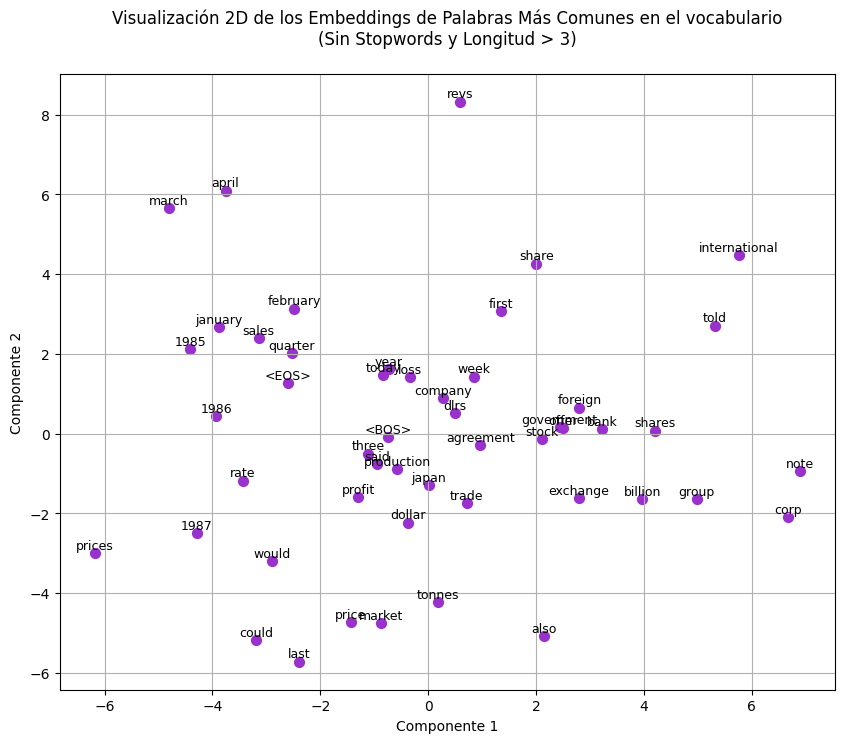

In [36]:
# Visualizar los resultados
plt.figure(figsize=(10, 8))

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='darkorchid', s=50)  # `s` para el tamaño de los puntos

# Añadir etiquetas por encima de los puntos
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1] + 0.1),  # `+ 0.1` coloca la etiqueta por encima del punto
                 fontsize=9, ha='center', color='black')  # `ha='center'` centra la etiqueta

plt.title('Visualización 2D de los Embeddings de Palabras Más Comunes en el vocabulario\n(Sin Stopwords y Longitud > 3)\n')

plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

### Análisis nociones semánticas

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
def similitud_coseno(word1, word2):
    """Calcula la similitud coseno entre dos vectores"""

    # Obtener sus embeddings
    embedding1 = word_embeddings_dict[word1]
    embedding2 = word_embeddings_dict[word2]

    # Calcular la similitud coseno
    cosine_sim = cosine_similarity([embedding1], [embedding2])
    print(f"Similitud coseno entre {word1} y {word2}: {cosine_sim[0][0]}")

In [39]:
similitud_coseno("february","january")
similitud_coseno("price","market")
similitud_coseno("march","april")
similitud_coseno("money","dollar")


Similitud coseno entre february y january: 0.23327726125717163
Similitud coseno entre price y market: 0.09531818330287933
Similitud coseno entre march y april: 0.3759090304374695
Similitud coseno entre money y dollar: -0.08380722254514694


In [42]:
from scipy.spatial.distance import cosine

word1 = 'rich'
word2 = 'money'
word3 = 'poor'
word4 = 'capital'
word5 = 'city'
word6 = 'country'

# Obtener los embeddings
embedding_rich = word_embeddings_dict[word1]
embedding_money = word_embeddings_dict[word2]
embedding_poor = word_embeddings_dict[word3]
embedding_capital = word_embeddings_dict[word4]
embedding_city = word_embeddings_dict[word5]
embedding_country = word_embeddings_dict[word6]

# Realizar las operaciones de analogía
analogy1_result = embedding_rich - embedding_money + embedding_poor
analogy2_result = embedding_capital - embedding_city + embedding_country

# Buscar las palabras más cercanas a los resultados de las analogías
def find_most_similar(analogy_result):
    similarities = {}
    for word, embedding in word_embeddings_dict.items():
        similarity = cosine(analogy_result, embedding)
        similarities[word] = similarity
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1])
    return sorted_similarities[:10]  # Retornar las 10 palabras más cercanas

# Ver los resultados de las analogías
print("Palabras más cercanas a 'rich - money + poor':")
for word, similarity in find_most_similar(analogy1_result):
    print(f"{word}: {similarity}")

print("\nPalabras más cercanas a 'capital - city + country':")
for word, similarity in find_most_similar(analogy2_result):
    print(f"{word}: {similarity}")

Palabras más cercanas a 'rich - money + poor':
rich: 0.3999361991882324
poor: 0.458340048789978
brian: 0.7339683771133423
di: 0.7362001538276672
trapped: 0.7513508200645447
chatsworth: 0.75420743227005
duluth: 0.7622594833374023
asbestec: 0.7640729546546936
wessanen: 0.7644728422164917
extraodinary: 0.7664402723312378

Palabras más cercanas a 'capital - city + country':
capital: 0.38265442848205566
country: 0.47400039434432983
governors: 0.7261853218078613
koninklijke: 0.7441940307617188
personnel: 0.7509213089942932
staying: 0.7524275779724121
funeral: 0.7556468844413757
mcandrews: 0.7614834308624268
webber: 0.7622212171554565
mikulic: 0.7622326612472534


### Conclusiones

El modelo muestra una buena capacidad para capturar relaciones semánticas claras, como las que existen entre palabras como "february" y "january", "price" y "market", o "money" y "dollar". Sin embargo, presenta dificultades al resolver analogías más complejas, como "rich - money + poor" o "capital - city + country". Esto sugiere que el modelo aún no maneja bien las analogías semánticas. En la visualización 2D, las palabras relacionadas con el tiempo y la economía están bien agrupadas, pero algunas palabras están más alejadas, lo que indica que el modelo podría mejorar en la representación de ciertas relaciones semánticas.

## Referencias

- [Language models - Lena Voita](https://lena-voita.github.io/nlp_course/language_modeling.html#generation_strategies)
- [A Neural Probabilistic Model - Bengio](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- Parte del código de esta práctica fue retomado del trabajo de la Dr. Ximena Guitierrez Vasques